### DATA PREP AND MODULE IMPORT

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import warnings
warnings. filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9,6)
from utility import set_global_determinism
set_global_determinism()

In [16]:
date_df = pd.read_csv('muringato-sensor6.csv')
df = pd.read_csv('original_set_raw.csv')
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [17]:
df_normalized = normalize(df)
dataset= df_normalized[df_normalized.columns[0:9]].to_numpy()

In [29]:
from utility import window_stage
sample_step = 7
x, y = window_stage(dataset, sample_step)
print(x.shape, y.shape)
# for i in range(len(x)):
#     print(x[i], y[i])

(287, 7, 8) (287,)


In [30]:
x.shape[1]*x.shape[2]

56

In [31]:
# length of each input vector = the number of time steps (samples ) * by the number of features or time series(stations). 
# 2 * 8 = 9
X = x.reshape((x.shape[0], (x.shape[1]*x.shape[2])))
X.shape

(287, 56)

In [32]:
data_size = int(x.shape[0] * .8)
x_train, y_train = X[:data_size], y[:data_size] 
x_test, y_test = X[data_size:], y[data_size:]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

x_test.shape

(58, 1, 56)

### LSTM 

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM, Bidirectional
from tensorflow.keras.utils import plot_model

In [34]:
# design network
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=70, validation_data=(x_test, y_test), verbose=0, shuffle=False)

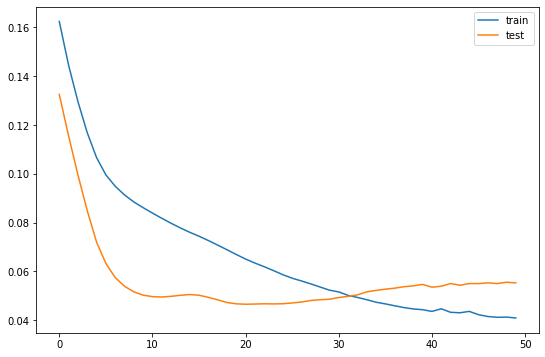

In [35]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [36]:
#prediction
import warnings
warnings. filterwarnings('ignore')
yhat = model.predict(x_test, verbose=0)
yhat = yhat.flatten()
yhat.shape

(58,)

In [37]:
#error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.078


In [38]:
#dates = df.time[:y_test.shape[0]]
df3 = date_df.tail(y_test.shape[0])
df4 = df3.drop(['Data'], axis = 1)
df4['y_test'] = y_test.tolist()
df4['y_pred'] = yhat.tolist()
df4[['time']] = df4[['time']].apply(pd.to_datetime,dayfirst=True)

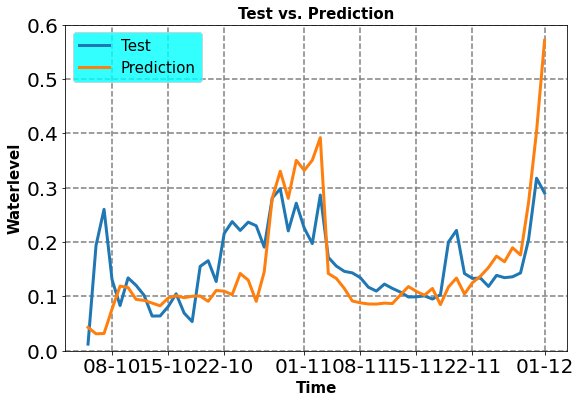

In [39]:
#Plot the output
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
Test, = plt.plot(df4['time'],y_test,linewidth=3, label='label1')
Prediction, = plt.plot(df4['time'], yhat, linewidth=3, label='label1')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('Test vs. Prediction',fontsize=15,weight = 'bold')
ax.set_xlabel('Time',fontsize=15,weight = 'bold')
ax.set_ylabel('Waterlevel',fontsize=15, weight = 'bold')
ax.set_ylim(0,0.6)
ax.tick_params(axis='both',labelsize=20)
ax.tick_params(axis = 'x', labelsize = 20)
ax.grid(True)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend(["Test", "Prediction"], loc ="upper left", fancybox=True,facecolor='#01FFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")
plt.savefig('rain_water.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()